# Simple example of Bayesian decoder with AYA data

This tutorial makes heavy use of tools from Nelpy. See the [link](https://github.com/nelpy/nelpy) for documentation.

In [134]:
%reload_ext autoreload
%autoreload 2

## Import packages that we need

In [135]:
import numpy as np
import statistics
import matplotlib.pyplot as plt
import pandas as pd
import nelpy as nel
import nelpy.plotting as npl
from nelpy.plotting.core import imagesc
from scipy import ndimage

from ripple_heterogeneity.utils import functions, loading
import seaborn as sns

## Load data

In [136]:
# lets use this session
# basepath = r"Z:\Data\GrosmarkAD\Achilles\Achilles_10252013"
basepath = r"Z:\Data\HMC1\day9"
# basepath = r"Z:\Data\Can\OML22\day19"
# basepath = r"Z:\Data\Can\OML22\day20"
# basepath = r"Z:\Data\Can\OML22\day6"
# basepath = r"Z:\Data\HMC1\day9"
# basepath = r"Z:\Data\AYAold\AB1\day1"

# basepath = r"Z:\Data\HMC1\day8"
# load our spikes
st, cell_metrics = loading.load_spikes(
    basepath, putativeCellType="Pyr", brainRegion="CA1"
)

# load session epochs, these are to find linear track epoch
epoch_df = loading.load_epoch(basepath)

# load animal position
beh_df = loading.load_animal_behavior(basepath)


## format data into nelpy arrays

In [137]:
def resample_behavior(beh_df, dt_new=30):
    beh_df_new = pd.DataFrame()
    beh_df_new['time'] = np.arange(beh_df.time.min(), beh_df.time.max(), 1/dt_new)
    beh_df_new['x'] =  np.interp(beh_df_new.time, beh_df.time, beh_df.x)
    beh_df_new['y'] = np.interp(beh_df_new.time, beh_df.time, beh_df.y)
    return beh_df_new

beh_epochs = nel.EpochArray([np.array([epoch_df.startTime, epoch_df.stopTime]).T])

# find linear track
idx = np.where(epoch_df.environment == "linear")[0]
beh_epochs_linear = beh_epochs[idx]

beh_df = resample_behavior(beh_df)

dt = statistics.mode(np.diff(beh_df.time))


beh_df.x = beh_df.x.interpolate(
    method="linear",
    limit=int(1 / dt) * 5,
)
beh_df.y = beh_df.y.interpolate(
    method="linear",
    limit=int(1 / dt) * 5,
)

beh_df.x = ndimage.median_filter( beh_df.x, size=int(1/dt*2))
beh_df.y = ndimage.median_filter( beh_df.y, size=int(1/dt*2))

# bad_idx = np.isnan(beh_df.x) | np.isnan(beh_df.y)
# beh_df = beh_df[~bad_idx]

# straighten out track linear
x, y = functions.linearize_position(beh_df.x, beh_df.y)

# make position array
pos = nel.AnalogSignalArray(
    data=np.array(x),
    timestamps=beh_df.time,
    fs=1 / dt,
)

# only include linear track
pos = pos[beh_epochs_linear]

# make min pos 0
pos.data = pos.data - np.nanmin(pos.data)

manipulation_epochs = loading.load_manipulation(
    basepath, struct_name="optoStim", merge_gap=1
)

if manipulation_epochs is not None:
    pos = pos[~manipulation_epochs]
    st = st[~manipulation_epochs]

## split linear track laps

You can see in the output that we have xx outbound and xx inbound laps

In [138]:
def find_good_laps(pos, dir_epoch, thres=0.5, binsize=6):
    """
    find_good_laps: finds good laps in behavior data
        Made to find good laps in nelpy array for replay analysis
    input:
        pos: nelpy analog array with single dim
        dir_epoch: epoch to flip
        thres: occupancy threshold for good lap
        binsize: size of bins to calculate occupancy
    output:
        good_laps: epoch array of good laps
    """
    # make bin edges to calc occupancy
    x_edges = np.arange(np.nanmin(pos.data[0]), np.nanmax(pos.data[0]), binsize)
    # initialize occupancy matrix (position x time)
    occ = np.zeros([len(x_edges) - 1, dir_epoch.n_intervals])
    # iterate through laps
    for i, ep in enumerate(dir_epoch):
        # bin position per lap
        occ[:, i], _ = np.histogram(pos[ep].data[0], bins=x_edges)
    # calc percent occupancy over position bins per lap and find good laps
    good_laps = np.where(~((np.sum(occ == 0, axis=0) / occ.shape[0]) > thres))[0]
    # if no good laps, return empty epoch
    if len(good_laps) == 0:
        dir_epoch = nel.EpochArray()
    else:
        dir_epoch = dir_epoch[good_laps]
    return dir_epoch

# get outbound and inbound epochs
(outbound_epochs, inbound_epochs) = functions.get_linear_track_lap_epochs(
    pos.abscissa_vals, pos.data[0], newLapThreshold=20, good_laps=False
)

outbound_epochs = find_good_laps(pos, outbound_epochs)
inbound_epochs = find_good_laps(pos, inbound_epochs)
print(outbound_epochs)
print(inbound_epochs)



<EpochArray at 0x214b278c7c0: 35 epochs> of length 23:44:533 minutes
<EpochArray at 0x214a6666bb0: 35 epochs> of length 27:49:266 minutes


## Inspect laps

Text(0, 0.5, 'linearized position (cm)')

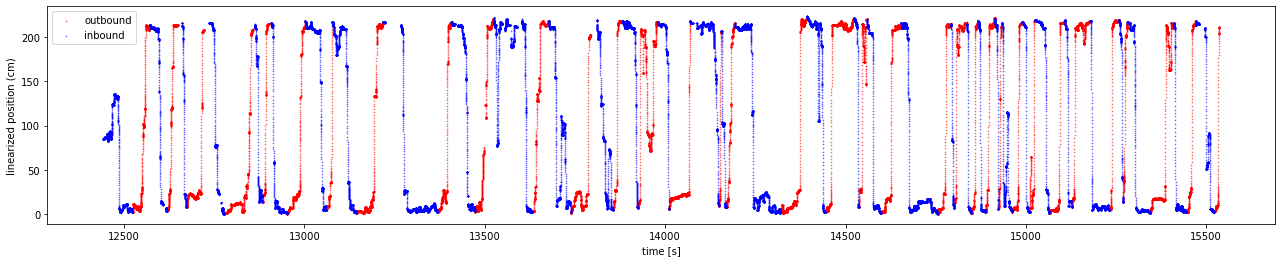

In [139]:
fig = plt.figure(figsize=(22, 4))
plt.scatter(
    pos[outbound_epochs].abscissa_vals,
    pos[outbound_epochs].data.T,
    color="red",
    marker=".",
    alpha=0.5,
    label="outbound",
    s=2,
)
plt.scatter(
    pos[inbound_epochs].abscissa_vals,
    pos[inbound_epochs].data.T,
    color="blue",
    marker=".",
    alpha=0.5,
    label="inbound",
    s=2,
)
plt.legend()

ax = plt.gca()
ax.set_xlabel("time [s]")
ax.set_ylabel("linearized position (cm)")


## Make tuning curves

We can make tuning curves separately for each direction, but here I'm simply making overall curves with both directions

In [140]:
# from scipy.ndimage import gaussian_filter

# def get_ratemap(ts, x, y, st, bin_width=3, smooth_sigma=3, add_nan_back=False):

#     fs = 1 / statistics.mode(np.diff(ts))

#     x_edges = np.arange(np.nanmin(x), np.nanmax(x), bin_width)
#     y_edges = np.arange(np.nanmin(y), np.nanmax(y), bin_width)

#     if len(y_edges) == 0:
#         y_edges = 1

#     occ, _, _ = np.histogram2d(x, y, bins=(x_edges, y_edges))
#     occ = occ / fs

#     spk_mat, _, _ = np.histogram2d(
#         np.interp(st, ts, x), np.interp(st, ts, y), bins=(x_edges, y_edges)
#     )

#     ratemap = spk_mat / occ
#     bad_idx = np.isnan(ratemap) | np.isinf(ratemap)
#     ratemap[bad_idx] = 0

#     ratemap = gaussian_filter(ratemap, sigma=smooth_sigma)

#     if add_nan_back:
#         ratemap[bad_idx] = np.nan

#     # ratemap = rotate(ratemap, angle=-90)
#     # occ = rotate(occ, angle=-90)

#     ratemap = np.fliplr(ratemap)
#     occ = np.fliplr(occ)

#     return ratemap, occ


# # compute and smooth speed
# speed1 = nel.utils.ddt_asa(pos[inbound_epochs], smooth=True, sigma=0.1, norm=True)

# # find epochs where the animal ran > Xcm/sec
# run_epochs = nel.utils.get_run_epochs(speed1, v1=4, v2=4)
# pos_temp = pos[inbound_epochs][run_epochs]

# cell = 0
# ratemap, occ = get_ratemap(
#     pos_temp.abscissa_vals,
#     pos_temp.data[0],
#     np.ones_like(pos_temp.data[0]),
#     st[inbound_epochs][run_epochs].data[cell],
#     bin_width=3,
#     smooth_sigma=1,
#     add_nan_back=False,
# )

# plt.plot(ratemap, color="red")
# plt.plot(tc.ratemap[cell], color="blue")

# plt.show()


In [148]:
def get_tuning_curves(
    pos, st_all, dir_epoch, speed_thres=4, ds=0.1, s_binsize=3, tuning_curve_sigma=3
):
    # compute and smooth speed
    speed1 = nel.utils.ddt_asa(pos[dir_epoch], smooth=True, sigma=0.1, norm=True)

    # find epochs where the animal ran > Xcm/sec
    run_epochs = nel.utils.get_run_epochs(speed1, v1=speed_thres, v2=speed_thres)

    # restrict spike trains to those epochs during which the animal was running
    st_run = st_all[dir_epoch][run_epochs]

    # smooth and re-bin:
    bst_run = st_run.bin(ds=ds)

    x_max = np.ceil(np.nanmax(pos[dir_epoch].data))
    x_min = np.floor(np.nanmin(pos[dir_epoch].data))

    n_bins = int((x_max - x_min) / s_binsize)

    tc = nel.TuningCurve1D(
        bst=bst_run,
        extern=pos[dir_epoch][run_epochs],
        n_extern=n_bins,
        extmin=x_min,
        extmax=x_max,
        sigma=tuning_curve_sigma,
        min_duration=0.1,
    )
    return tc, st_run, bst_run, run_epochs


# combine inbound outbound to single array
all_epochs = inbound_epochs | outbound_epochs

# call the above def to make tuning curves
tc, st_run, bst_run, run_epochs = get_tuning_curves(pos, st, inbound_epochs, tuning_curve_sigma=3)


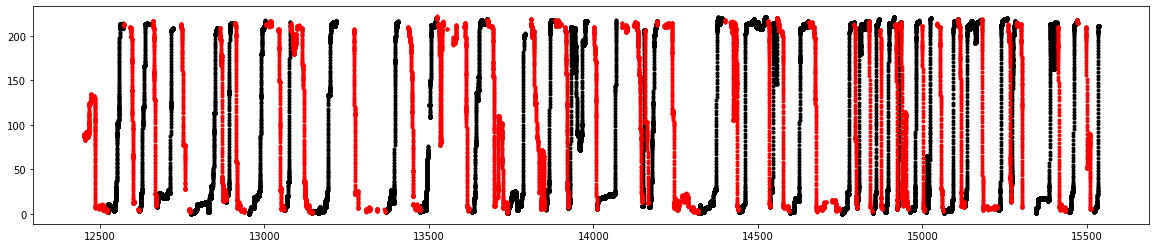

In [149]:
plt.figure(figsize=(20, 4))
plt.plot(pos[outbound_epochs].abscissa_vals, pos[outbound_epochs].data[0], ".k")

plt.plot(pos[run_epochs].abscissa_vals, pos[run_epochs].data[0], ".r")

## Select place cells

Here, I look for cells with at least 100 spikes, at least 1hz peak rate, and at least a 1.5 peak to mean fr ratio

In [150]:
def restrict_to_place_cells(
    tc,
    st_run,
    bst_run,
    st_all,
    cell_metrics,
    place_cell_min_spks=100,
    place_cell_min_rate=1,
    place_cell_peak_mean_ratio=1.5,
):
    # locate pyr cells with >= 100 spikes, peak rate >= 1 Hz, peak/mean ratio >=1.5
    peak_firing_rates = tc.max(axis=1)
    mean_firing_rates = tc.mean(axis=1)
    ratio = peak_firing_rates / mean_firing_rates

    idx = (
        (st_run.n_events >= place_cell_min_spks)
        & (tc.ratemap.max(axis=1) >= place_cell_min_rate)
        & (ratio >= place_cell_peak_mean_ratio)
    )
    unit_ids_to_keep = (np.where(idx)[0] + 1).squeeze().tolist()

    sta_placecells = st_all._unit_subset(unit_ids_to_keep)
    tc = tc._unit_subset(unit_ids_to_keep)
    total_units = sta_placecells.n_active
    bst_run = bst_run.loc[:, unit_ids_to_keep]

    # restrict cell_metrics to place cells
    cell_metrics_ = cell_metrics[idx]

    return sta_placecells, tc, bst_run, cell_metrics_, total_units


(sta_placecells, tc, bst_run, cell_metrics_, total_units) = restrict_to_place_cells(
    tc, st_run, bst_run, st, cell_metrics, place_cell_peak_mean_ratio=1
)


## visualize place cells 

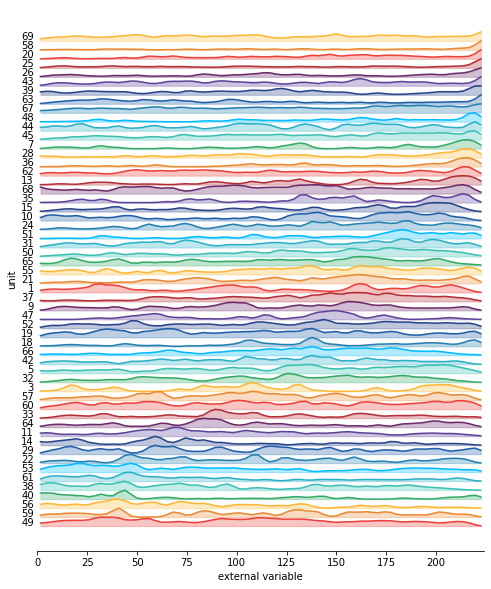

In [151]:
tc = tc.reorder_units()
npl.set_palette(npl.colors.rainbow)
with npl.FigureManager(show=True, figsize=(8, 10)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    npl.plot_tuning_curves1D(tc, normalize=True, pad=1)


## Decode position using tuning curves and binned firing rate

Here the colormap is the posterior probability of the rat's position

The greenish color is the rats actual position

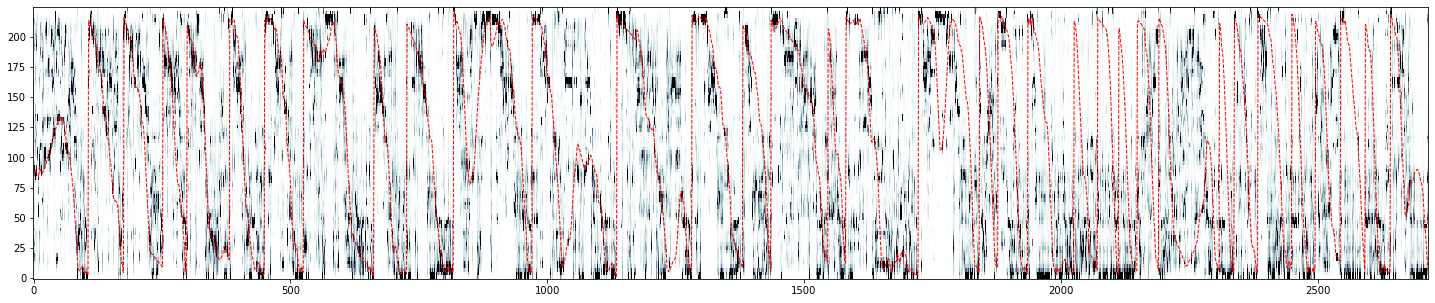

In [152]:
# this line runs the decoder
posteriors, lengths, mode_pth, mean_pth = nel.decoding.decode1D(
    bst_run, tc, xmin=np.nanmin(pos.data), xmax=np.nanmax(pos.data)
)

fig = plt.figure(figsize=(25, 5))
ax = plt.gca()
n_ext, n_bins = posteriors.shape
imagesc(
    x=np.arange(n_bins),
    y=np.arange(int(tc.bins[-1] + 1)),
    data=posteriors,
    cmap="bone_r",
    ax=ax,
    vmax=0.1,
)

plt.plot(pos(bst_run.bin_centers), "r", linewidth=1, linestyle="--")


### Let's zoom in

(0.0, 400.0)

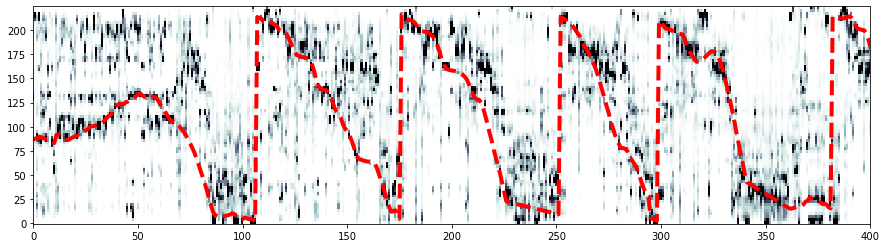

In [153]:
fig = plt.figure(figsize=(15, 4))
ax = plt.gca()
n_ext, n_bins = posteriors.shape
imagesc(
    x=np.arange(n_bins),
    y=np.arange(int(tc.bins[-1] + 1)),
    data=posteriors,
    cmap="bone_r",
    ax=ax,
    vmax=0.1,
)

plt.plot(pos(bst_run.bin_centers), "r", linewidth=4, linestyle="--")
plt.xlim(0, 400)


## We can compare actual vs. decoded all together

36.28912690987338

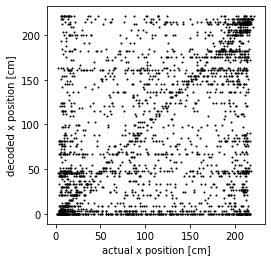

In [155]:
plt.scatter(pos(bst_run.bin_centers), mode_pth, color="k", s=1)
plt.axis("square")
# plt.axis("equal")

plt.xlabel("actual x position [cm]")
plt.ylabel("decoded x position [cm]")


actual_pos = pos(bst_run.bin_centers)
median_error = np.nanmedian(np.abs(actual_pos - mode_pth))

median_error